In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Add helper functions

In [2]:
def change_money(value):
    """
    Takes money value as string and converts it to float value format.
    """
    if type(value) == str:
        return float(value.replace("$", "").replace(",", ""))
    else:
        return float(value)

# Load listings, calander, and reviews of Seattle Airbnb

In [3]:
seattle_listings = pd.read_csv('./seattle_dataset/listings.csv')
print(seattle_listings.shape)
seattle_listings.head()

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
seattle_calendar = pd.read_csv("./seattle_dataset/calendar.csv")
print(seattle_calendar.shape)
seattle_calendar.head()

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
seattle_reviews = pd.read_csv("./seattle_dataset/reviews.csv")
print(seattle_reviews.shape)
seattle_reviews.head()

(84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [6]:
print(seattle_listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

# Clean and modify the data frame

In [7]:
# change the data type of date
seattle_calendar['date'] = pd.DatetimeIndex(seattle_calendar['date']).astype('datetime64[ns]')
seattle_calendar['price'] = seattle_calendar['price'].apply(change_money)

# Only available listings have prices

In [8]:
sum(seattle_calendar[seattle_calendar['available'] == 'f']['price'].notnull())

0

In [9]:
sum(seattle_calendar[seattle_calendar['available'] == 't']['price'].isnull())

0

# Get the available listings

In [10]:
seattle_calendar_available = seattle_calendar[seattle_calendar['available'] == 't']
seattle_calendar_available.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0


# The seattle dataset contains the listings for one year

In [11]:
print(min(seattle_calendar['date']), max(seattle_calendar['date']))

2016-01-04 00:00:00 2017-01-02 00:00:00


# Monthly Inventory of Seattle Airbnb

<AxesSubplot:xlabel='date'>

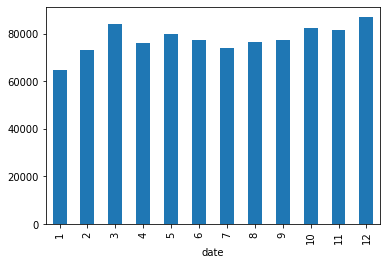

In [12]:
seattle_inventory = seattle_calendar_available['listing_id'].groupby(seattle_calendar['date'].dt.month).count()
seattle_inventory.plot(kind = 'bar')

# Monthly-averaged Price of Seattle Airbnb

<AxesSubplot:xlabel='date'>

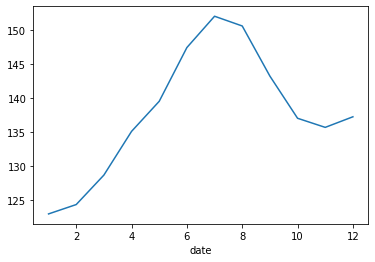

In [13]:
seattle_price = seattle_calendar_available['price'].groupby(seattle_calendar['date'].dt.month).mean()
seattle_price.plot()

# Daily-averaged price of Seattle Airbnb

In [14]:
seattle_calendar_available.set_index('date', inplace=True)
seattle_calendar_available_d= seattle_calendar_available['price'].resample('D')

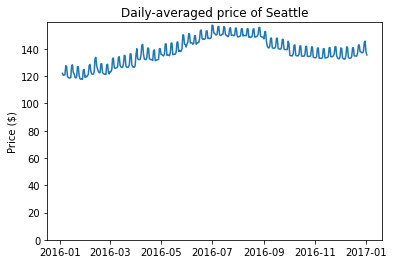

In [15]:
plt.plot(seattle_calendar_available_d.mean())
plt.title('Daily-averaged price of Seattle')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.ylabel('Price ($)')
plt.show()

# Load listings, calander, and reviews of Boston Airbnb

In [16]:
boston_calendar = pd.read_csv("./boston_dataset/calendar.csv")
print(boston_calendar.shape)
boston_calendar.head()

(1308890, 4)


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


# Clean and modify the data frame

In [17]:
# change the data type of date
boston_calendar['date'] = pd.DatetimeIndex(boston_calendar['date']).astype('datetime64[ns]')
boston_calendar['price'] = boston_calendar['price'].apply(change_money)

# Only available listings have prices

In [18]:
sum(boston_calendar[boston_calendar['available'] == 'f']['price'].notnull())

0

In [19]:
sum(boston_calendar[boston_calendar['available'] == 't']['price'].isnull())

0

# Get the available listings


In [20]:
boston_calendar_available = boston_calendar[boston_calendar['available'] == 't']
boston_calendar_available.head()

,listing_id,date,available,price
365,3075044,2017-08-22,t,65.0
366,3075044,2017-08-21,t,65.0
367,3075044,2017-08-20,t,65.0
368,3075044,2017-08-19,t,75.0
369,3075044,2017-08-18,t,75.0


# The Boston dataset contains the listings for one year

In [21]:
print(min(boston_calendar['date']), max(boston_calendar['date']))

2016-09-06 00:00:00 2017-09-05 00:00:00


# Monthly Inventory of Boston Airbnb

<AxesSubplot:xlabel='date'>

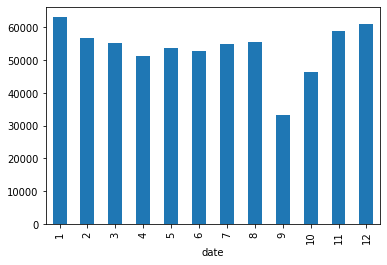

In [22]:
boston_inventory = boston_calendar_available['listing_id'].groupby(boston_calendar['date'].dt.month).count()
boston_inventory.plot(kind = 'bar')

# Monthly-averaged Price of Boston Airbnb

<AxesSubplot:xlabel='date'>

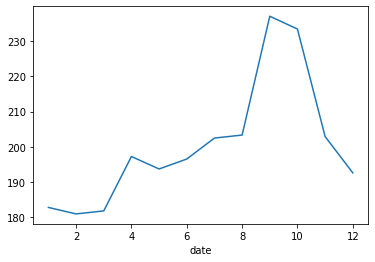

In [23]:
boston_price = boston_calendar_available['price'].groupby(boston_calendar['date'].dt.month).mean()
boston_price.plot()

# Daily-averaged Price of Seattle Airbnb

In [24]:
boston_calendar_available.set_index('date', inplace=True)
boston_calendar_available_d= boston_calendar_available['price'].resample('D')

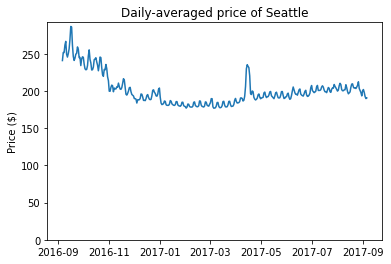

In [25]:
plt.plot(boston_calendar_available_d.mean())
plt.title('Daily-averaged price of Seattle')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.ylabel('Price ($)')
plt.show()

# Inventory comparsion between Seattle and Boston

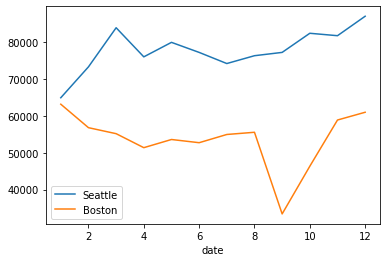

In [27]:
ax = seattle_inventory.plot()
boston_inventory.plot(ax=ax)
plt.legend(['Seattle', 'Boston'])

# Price comparsion between Seattle and Boston

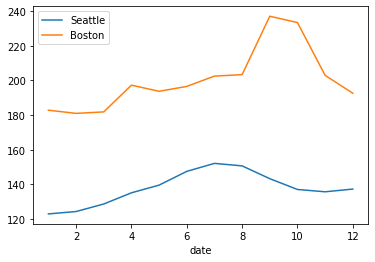

In [28]:
ax = seattle_price.plot()
boston_price.plot(ax=ax)
plt.legend(['Seattle', 'Boston'])